# 2 Small Worlds and Large Worlds

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
from matplotlib.lines import Line2D
from tabulate import tabulate

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## 2.1 The garden of forking data

### 2.1.1 Counting possibilities 

In [3]:
garden = pd.DataFrame({
    "p1": np.repeat(0, 4),
    "p2": np.repeat([1, 0], [1, 3]),
    "p3": np.repeat([1, 0], [2, 2]),
    "p4": np.repeat([1, 0], [3, 1]),
    "p5": np.repeat(1, 4),
})

garden.head()

,p1,p2,p3,p4,p5
0,0,1,1,1,1
1,0,0,1,1,1
2,0,0,0,1,1
3,0,0,0,0,1


In [4]:
garden["x"] = range(1, 5)
garden_melt = garden.melt(
    id_vars=["x"], value_vars=["p1", "p2", "p3", "p4", "p5"], var_name="possibility"
)
garden_melt["color"] = garden_melt["value"].map(dict(zip([0, 1], ["white", "navy"])))

garden_melt.head(8)

,x,possibility,value,color
0,1,p1,0,white
1,2,p1,0,white
2,3,p1,0,white
3,4,p1,0,white
4,1,p2,1,navy
5,2,p2,0,white
6,3,p2,0,white
7,4,p2,0,white


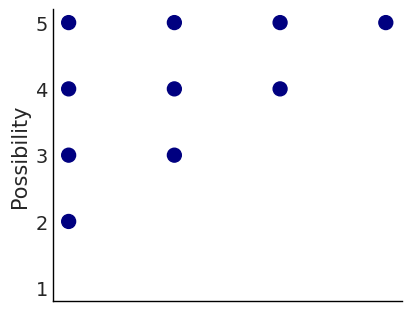

In [5]:
_, ax = plt.subplots(figsize=(4, 3))

ax.scatter(garden_melt["x"], garden_melt["possibility"], c=garden_melt["color"], s=100)

ax.set(ylabel="Possibility")
ax.set(xticks=[], yticks=range(5), yticklabels=range(1, 6))
plt.show()

In [6]:
df = pd.DataFrame({"draw": [1, 2, 3], "marbles": [4, 4, 4]})  # noqa: PD901
df["possibilities"] = df["marbles"] ** df["draw"]
table = tabulate(
    df,
    headers="keys",
    tablefmt="simple_outline",
    colalign=["right"] * 3,
    showindex=False,
)

print(table)

┌────────┬───────────┬─────────────────┐
│   draw │   marbles │   possibilities │
├────────┼───────────┼─────────────────┤
│      1 │         4 │               4 │
│      2 │         4 │              16 │
│      3 │         4 │              64 │
└────────┴───────────┴─────────────────┘


In [7]:
d = pd.DataFrame({
    "position": np.concatenate([
        np.arange(1, 4**1 + 1) / 4**0,
        np.arange(1, 4**2 + 1) / 4**1,
        np.arange(1, 4**3 + 1) / 4**2,
    ]),
    "draw": np.repeat(np.arange(1, 4), repeats=(4**1, 4**2, 4**3)),
    "fill": np.tile(np.repeat(["navy", "white"], repeats=(1, 3)), 4**0 + 4**1 + 4**2),
})

d

,position,draw,fill
0,1.0000,1,navy
1,2.0000,1,white
2,3.0000,1,white
3,4.0000,1,white
4,0.2500,2,navy
...,...,...,...
79,3.7500,3,white
80,3.8125,3,navy
81,3.8750,3,white
82,3.9375,3,white


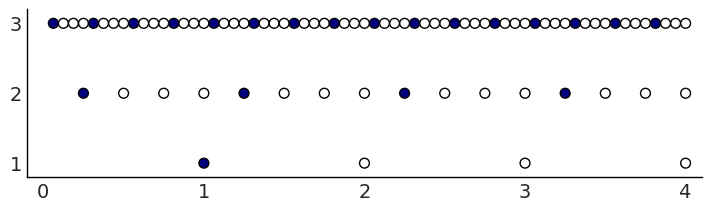

In [8]:
_, ax = plt.subplots(figsize=(7, 2))

ax.scatter(d["position"], d["draw"], c=d["fill"], s=50, edgecolors="black")
ax.set(xlim=(-0.1, 4.1), ylim=(0.8, 3.2), xticks=np.arange(5), yticks=[1, 2, 3])

plt.show()

In [9]:
d["denominator"] = d["draw"].map(
    dict(zip([1, 2, 3], [0.5 / 4**0, 0.5 / 4**1, 0.5 / 4**2]))
)

d

,position,draw,fill,denominator
0,1.0000,1,navy,0.50000
1,2.0000,1,white,0.50000
2,3.0000,1,white,0.50000
3,4.0000,1,white,0.50000
4,0.2500,2,navy,0.12500
...,...,...,...,...
79,3.7500,3,white,0.03125
80,3.8125,3,navy,0.03125
81,3.8750,3,white,0.03125
82,3.9375,3,white,0.03125


In [10]:
lines_1 = pd.DataFrame({
    "x": np.repeat(np.arange(1, 4**1 + 1), repeats=4) - 0.5 / 4**0,
    "xend": np.arange(1, 4**2 + 1) / 4 - 0.5 / 4**1,
    "y": np.repeat(1, repeats=4**2),
    "yend": np.repeat(2, repeats=4**2),
})

lines_1

,x,xend,y,yend
0,0.5,0.125,1,2
1,0.5,0.375,1,2
2,0.5,0.625,1,2
3,0.5,0.875,1,2
4,1.5,1.125,1,2
5,1.5,1.375,1,2
6,1.5,1.625,1,2
7,1.5,1.875,1,2
8,2.5,2.125,1,2
9,2.5,2.375,1,2


In [11]:
lines_2 = pd.DataFrame({
    "x": np.repeat(np.arange(1, 4**2 + 1) / 4, repeats=4) - 0.5 / 4**1,
    "xend": np.arange(1, 4**3 + 1) / 4**2 - 0.5 / 4**2,
    "y": np.repeat(2, repeats=4**3),
    "yend": np.repeat(3, repeats=4**3),
})

lines_2

,x,xend,y,yend
0,0.125,0.03125,2,3
1,0.125,0.09375,2,3
2,0.125,0.15625,2,3
3,0.125,0.21875,2,3
4,0.375,0.28125,2,3
...,...,...,...,...
59,3.625,3.71875,2,3
60,3.875,3.78125,2,3
61,3.875,3.84375,2,3
62,3.875,3.90625,2,3


In [12]:
d["position"] = d["position"] - d["denominator"]
d

,position,draw,fill,denominator
0,0.50000,1,navy,0.50000
1,1.50000,1,white,0.50000
2,2.50000,1,white,0.50000
3,3.50000,1,white,0.50000
4,0.12500,2,navy,0.12500
...,...,...,...,...
79,3.71875,3,white,0.03125
80,3.78125,3,navy,0.03125
81,3.84375,3,white,0.03125
82,3.90625,3,white,0.03125


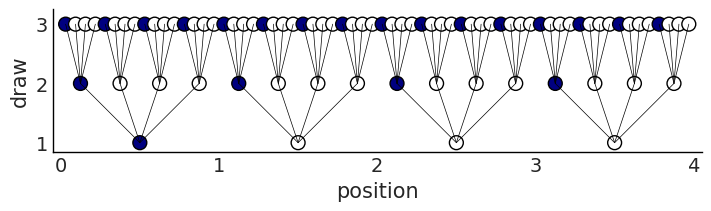

In [13]:
_, ax = plt.subplots(figsize=(7, 2))

polar_factor = np.pi / 2

for _, row in lines_1.iterrows():
    ax.add_line(
        Line2D(
            [row["x"], row["xend"]],
            [row["y"], row["yend"]],
            color="black",
            linewidth=1 / 2,
        )
    )

for _, row in lines_2.iterrows():
    ax.add_line(
        Line2D(
            [row["x"], row["xend"]],
            [row["y"], row["yend"]],
            color="black",
            linewidth=1 / 2,
        )
    )


ax.scatter(d["position"], d["draw"], c=d["fill"], edgecolors="black", s=100)


ax.set(xlim=(-0.05, 4.05), ylim=(0.85, 3.25), xticks=np.arange(5), yticks=[1, 2, 3])

ax.set(xlabel="position", ylabel="draw")
plt.show()

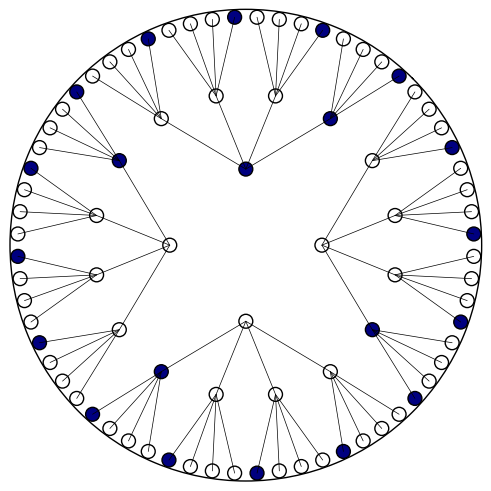

In [14]:
_, ax = plt.subplots(subplot_kw={"projection": "polar"})

polar_factor = np.pi / 2

for _, row in lines_1.iterrows():
    ax.add_line(
        Line2D(
            [row["x"] * polar_factor, row["xend"] * polar_factor],
            [row["y"] * polar_factor, row["yend"] * polar_factor],
            color="black",
            linewidth=1 / 2,
        )
    )

for _, row in lines_2.iterrows():
    ax.add_line(
        Line2D(
            [row["x"] * polar_factor, row["xend"] * polar_factor],
            [row["y"] * polar_factor, row["yend"] * polar_factor],
            color="black",
            linewidth=1 / 2,
        )
    )


ax.scatter(
    d["position"] * polar_factor,
    d["draw"] * polar_factor,
    c=d["fill"],
    edgecolors="black",
    s=100,
)

ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set(
    xticks=np.arange(4) * polar_factor,
    xticklabels=[],
    yticks=[],
    theta_offset=polar_factor / 2,
)

plt.show()

In [15]:
# create the data
t = pd.DataFrame({
    "d1": ["w", "b", "b", "b", "b"],
    "d2": ["w", "w", "b", "b", "b"],
    "d3": ["w", "w", "w", "b", "b"],
    "d4": ["w", "w", "w", "w", "b"],
})

# apply the functions and calculate the product
t["blue1"] = np.sum(t.to_numpy() == "b", axis=1)
t["white"] = np.sum(t.to_numpy() == "w", axis=1)
t["blue2"] = np.sum(t.to_numpy() == "b", axis=1)
t["product"] = t["blue1"] * t["white"] * t["blue2"]

t

,d1,d2,d3,d4,blue1,white,blue2,product
0,w,w,w,w,0,4,0,0
1,b,w,w,w,1,3,1,3
2,b,b,w,w,2,2,2,8
3,b,b,b,w,3,1,3,9
4,b,b,b,b,4,0,4,0


In [16]:
t1 = pd.DataFrame({
    "Conjecture": "[" + t["d1"] + " " + t["d2"] + " " + t["d3"] + " " + t["d4"] + "]",
    "Ways to produce [w b w]": t["blue1"].astype(str)
    + " * "
    + t["white"].astype(str)
    + " * "
    + t["blue2"].astype(str)
    + " = "
    + t["product"].astype(str),
})

t1.style.set_properties(**{"text-align": "center", "font-family": "Andale Mono"})

,Conjecture,Ways to produce [w b w]
0,[w w w w],0 * 4 * 0 = 0
1,[b w w w],1 * 3 * 1 = 3
2,[b b w w],2 * 2 * 2 = 8
3,[b b b w],3 * 1 * 3 = 9
4,[b b b b],4 * 0 * 4 = 0


### 2.1.2 Combining other information

In [17]:
t2 = pd.DataFrame({
    "Conjecture": t1["Conjecture"],
    "Ways to produce [b]": t["blue1"],
    "Prior counts": t["product"],
})

t2["New count"] = (
    t2["Ways to produce [b]"].astype(str)
    + " * "
    + t2["Prior counts"].astype(str)
    + " = "
    + (t2["Ways to produce [b]"] * t2["Prior counts"]).astype(str)
)

t2.style.set_properties(**{"text-align": "center", "font-family": "Andale Mono"})

,Conjecture,Ways to produce [b],Prior counts,New count
0,[w w w w],0,0,0 * 0 = 0
1,[b w w w],1,3,1 * 3 = 3
2,[b b w w],2,8,2 * 8 = 16
3,[b b b w],3,9,3 * 9 = 27
4,[b b b b],4,0,4 * 0 = 0


In [18]:
t3 = pd.DataFrame({
    "Conjecture": "[" + t["d1"] + " " + t["d2"] + " " + t["d3"] + " " + t["d4"] + "]",
    "Prior counts": t["blue1"] * t["product"],
    "Factory count": np.r_[np.array([0]), np.arange(3, -1, -1)],
})

t3["New count"] = (
    t3["Prior counts"].astype(str)
    + " * "
    + t3["Factory count"].astype(str)
    + " = "
    + (t3["Prior counts"] * t3["Factory count"]).astype(str)
)

t3.style.set_properties(**{"text-align": "center", "font-family": "Andale Mono"})

,Conjecture,Prior counts,Factory count,New count
0,[w w w w],0,0,0 * 0 = 0
1,[b w w w],3,3,3 * 3 = 9
2,[b b w w],16,2,16 * 2 = 32
3,[b b b w],27,1,27 * 1 = 27
4,[b b b b],0,0,0 * 0 = 0


### 2.1.3 From counts to probability

Code 2.1

In [19]:
ways = np.array(t["product"])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

In [20]:
t4 = pd.DataFrame({
    "Possible composition": "["
    + t["d1"]
    + " "
    + t["d2"]
    + " "
    + t["d3"]
    + " "
    + t["d4"]
    + "]",
    "*p*": t["blue1"] / 4,
    "Ways to produce data": ways,
    "Plausibility": ways / ways.sum(),
})

t4.style.set_properties(**{
    "text-align": "center",
    "font-family": "Andale Mono",
}).format(precision=2)

,Possible composition,*p*,Ways to produce data,Plausibility
0,[w w w w],0.00,0,0.00
1,[b w w w],0.25,3,0.15
2,[b b w w],0.50,8,0.40
3,[b b b w],0.75,9,0.45
4,[b b b b],1.00,0,0.00


## 2.2 Building a model

### 2.2.1 A data story

### 2.2.2 Bayesian updating

In [21]:
toss = np.array(["w", "l", "w", "w", "w", "l", "w", "l", "w"])
n_trials = np.arange(1, 10)
n_success = np.cumsum(toss == "w")

toss_df = pd.DataFrame({"toss": toss, "n_trials": n_trials, "n_success": n_success})

toss_df

,toss,n_trials,n_success
0,w,1,1
1,l,2,1
2,w,3,2
3,w,4,3
4,w,5,4
5,l,6,4
6,w,7,5
7,l,8,5
8,w,9,6


In [22]:
import itertools

sequence_length = 50
# Create a list of values for p_water
p_water_values = np.linspace(0, 1, sequence_length)

# Create a list of all possible combinations of p_water and n_trials
expanded_grid = pd.DataFrame(
    list(itertools.product(n_trials, p_water_values)), columns=["n_trials", "p_water"]
)

# Merge the expanded grid with the original data frame
toss_final = toss_df.merge(expanded_grid, on="n_trials")
toss_final

,toss,n_trials,n_success,p_water
0,w,1,1,0.000000
1,w,1,1,0.020408
2,w,1,1,0.040816
3,w,1,1,0.061224
4,w,1,1,0.081633
...,...,...,...,...
445,w,9,6,0.918367
446,w,9,6,0.938776
447,w,9,6,0.959184
448,w,9,6,0.979592


In [23]:
toss_final["lagged_n_trials"] = toss_final.groupby("p_water")["n_trials"].shift(1)
toss_final["lagged_n_success"] = toss_final.groupby("p_water")["n_success"].shift(1)

toss_final["prior"] = np.where(
    toss_final["n_trials"] == 1,
    0.5,
    stats.binom.pmf(
        toss_final["lagged_n_success"],
        toss_final["lagged_n_trials"],
        toss_final["p_water"],
    ),
)

toss_final["likelihood"] = stats.binom.pmf(
    toss_final["n_success"], toss_final["n_trials"], toss_final["p_water"]
)

toss_final["prior"] = toss_final.groupby("n_trials", group_keys=False)["prior"].apply(
    lambda x: x / x.sum()
)

toss_final["likelihood"] = toss_final.groupby("n_trials", group_keys=False)[
    "likelihood"
].apply(lambda x: x / x.sum())

toss_final["strip"] = "n = " + toss_final["n_trials"].astype(str)
toss_final

,toss,n_trials,n_success,p_water,lagged_n_trials,lagged_n_success,prior,likelihood,strip
0,w,1,1,0.000000,NaN,NaN,0.020000,0.000000,n = 1
1,w,1,1,0.020408,NaN,NaN,0.020000,0.000816,n = 1
2,w,1,1,0.040816,NaN,NaN,0.020000,0.001633,n = 1
3,w,1,1,0.061224,NaN,NaN,0.020000,0.002449,n = 1
4,w,1,1,0.081633,NaN,NaN,0.020000,0.003265,n = 1
...,...,...,...,...,...,...,...,...,...
445,w,9,6,0.918367,8.0,5.0,0.003655,0.005595,n = 9
446,w,9,6,0.938776,8.0,5.0,0.001721,0.002693,n = 9
447,w,9,6,0.959184,8.0,5.0,0.000568,0.000908,n = 9
448,w,9,6,0.979592,8.0,5.0,0.000079,0.000129,n = 9


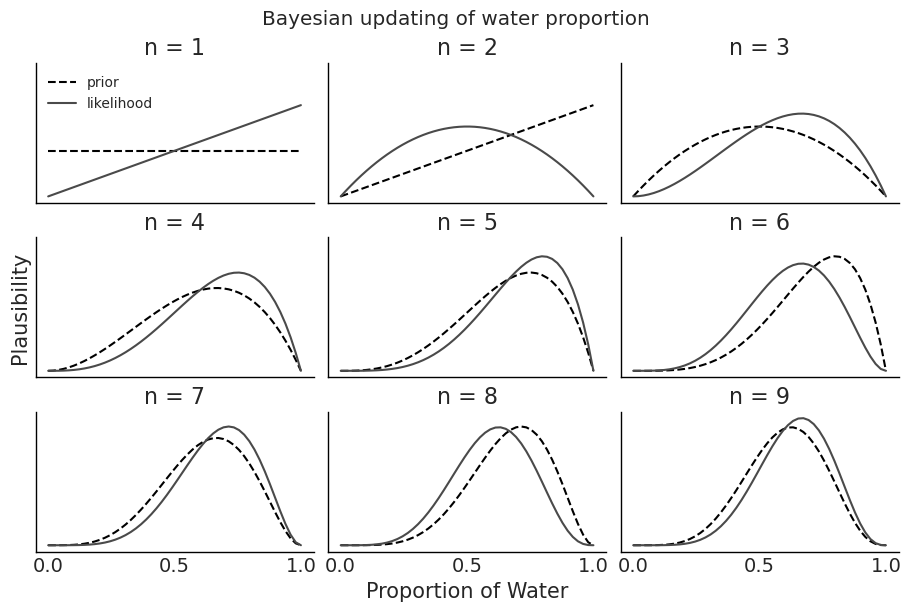

In [24]:
_, axes = plt.subplots(3, 3, figsize=(9, 6), sharex=True, sharey=True)

for (_, group), ax in zip(toss_final.groupby("strip"), axes.flatten()):
    ax.plot(group["p_water"], group["prior"], linestyle="--", label="prior")
    ax.plot(group["p_water"], group["likelihood"], label="likelihood")
    ax.set(title=group["strip"].unique()[0], xticks=[0, 0.5, 1.0], yticks=[])
    ax.grid(0)

axes[0, 0].legend(fontsize="medium")
axes[1, 0].set(ylabel="Plausibility")
axes[2, 1].set(xlabel="Proportion of Water")

plt.suptitle("Bayesian updating of water proportion", fontsize="x-large")
plt.show()

### 2.2.3 Evaluate

## 2.3 Components of the model

### 2.3.1 Variables

### 2.3.2 Definitions.

#### 2.3.2.1 Observed variables

Code 2.2

$$Pr(w \mid n, p) =  \frac{n!}{w!(n − w)!} p^w (1 − p)^{n−w}$$

The probability of observing six W’s in nine tosses — below a value of $p=0.5$.


In [25]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000003

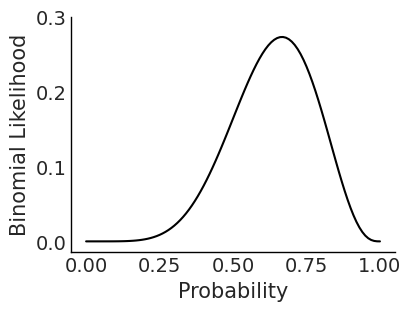

In [26]:
df2 = pd.DataFrame({"prob": np.arange(0, 1.01, 0.01)})

_, ax = plt.subplots(figsize=(4, 3))

ax.plot(df2["prob"], stats.binom.pmf(6, 9, df2["prob"]))
ax.set(xlabel="Probability", ylabel="Binomial Likelihood", yticks=[0, 0.1, 0.2, 0.3])
ax.grid(False)

plt.show()

#### 2.3.2.2 Unobserved variables

#### 2.3.2.3 Overthinking: Prior as a probability distribution

In [27]:
df3 = pd.DataFrame({"a": [0] * 5, "b": [1, 1.5, 2, 3, 9]})

parameter_space = np.linspace(start=0, stop=9, num=500)

df3 = pd.DataFrame(
    list(itertools.product(df3["a"], df3["b"], parameter_space)),
    columns=["a", "b", "parameter_space"],
)

df3["prob"] = stats.uniform.pdf(
    df3["parameter_space"], loc=df3["a"], scale=df3["b"] - df3["a"]
)
df3

,a,b,parameter_space,prob
0,0,1.0,0.000000,1.000000
1,0,1.0,0.018036,1.000000
2,0,1.0,0.036072,1.000000
3,0,1.0,0.054108,1.000000
4,0,1.0,0.072144,1.000000
...,...,...,...,...
12495,0,9.0,8.927856,0.111111
12496,0,9.0,8.945892,0.111111
12497,0,9.0,8.963928,0.111111
12498,0,9.0,8.981964,0.111111


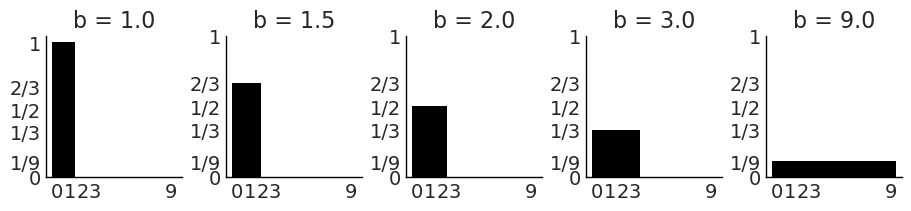

In [28]:
_, axes = plt.subplots(1, 5, figsize=(9, 2))

for (b, group), ax in zip(df3.groupby("b"), axes.flatten()):
    ax.bar(group["parameter_space"], group["prob"])
    ax.set(
        title=f"b = {b}",
        xticks=[0, 1, 2, 3, 9],
        yticks=[0, 1 / 9, 1 / 3, 1 / 2, 2 / 3, 1],
        yticklabels=["0", "1/9", "1/3", "1/2", "2/3", "1"],
    )
    ax.grid(0)

plt.show()

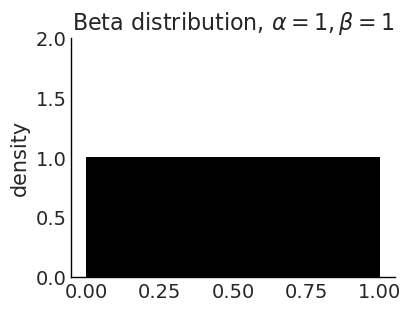

In [29]:
df4 = pd.DataFrame({"parameter_space": np.linspace(0, 1, 50)})
df4["prob"] = stats.beta.pdf(df4["parameter_space"], 1, 1)

_, ax = plt.subplots(figsize=(4, 3))

ax.fill_between(df4["parameter_space"], df4["prob"])
ax.set(ylim=[0, 2], ylabel="density", title=r"Beta distribution, $α=1, β=1$")
ax.grid(0)
plt.show()

#### 2.3.2.4 Rethinking: Datum or parameter?

### 2.3.3 A model is born

## 2.4 Making the model go

### 2.4.1 Bayes’ theorem

In [30]:
sequence_length = 1000

col_values = [["flat", "stepped", "LaPlace"], np.linspace(0, 1, sequence_length)]

grid = [*itertools.product(*col_values)]

df5 = pd.DataFrame(grid, columns=["row", "probability"])
df5

,row,probability
0,flat,0.000000
1,flat,0.001001
2,flat,0.002002
3,flat,0.003003
4,flat,0.004004
...,...,...
2995,LaPlace,0.995996
2996,LaPlace,0.996997
2997,LaPlace,0.997998
2998,LaPlace,0.998999


In [31]:
df5["prior"] = np.where(
    df5["row"] == "flat",
    1,
    np.where(
        df5["row"] == "stepped",
        np.repeat([0, 1], sequence_length / 2 * 3),
        np.exp(-abs(df5["probability"] - 0.5) / 0.25) / (2 * 0.25),
    ),
)

df5["likelihood"] = stats.binom.pmf(6, 9, df5["probability"])
df5

,row,probability,prior,likelihood
0,flat,0.000000,1.000000,0.000000e+00
1,flat,0.001001,1.000000,8.425225e-17
2,flat,0.002002,1.000000,5.375951e-15
3,flat,0.003003,1.000000,6.105137e-14
4,flat,0.004004,1.000000,3.419945e-13
...,...,...,...,...
2995,LaPlace,0.995996,0.275041,5.263909e-06
2996,LaPlace,0.996997,0.273941,2.234136e-06
2997,LaPlace,0.997998,0.272847,6.659641e-07
2998,LaPlace,0.998999,0.271757,8.374775e-08


In [32]:
df5_final = (
    df5.groupby("row", group_keys=False)[["row", "probability", "prior", "likelihood"]]
    .apply(
        lambda x: x.assign(
            posterior=x["prior"] * x["likelihood"] / sum(x["prior"] * x["likelihood"])
        )
    )
    .melt(
        id_vars=["row", "probability"],
        value_vars=["prior", "likelihood", "posterior"],
        var_name="name",
        value_name="value",
    )
    .reset_index(drop=True)
)


df5_final["row"] = pd.Categorical(
    df5_final["row"], categories=["flat", "stepped", "LaPlace"]
)
df5_final["name"] = pd.Categorical(
    df5_final["name"], categories=["prior", "likelihood", "posterior"]
)

df5_final.sort_values(["row", "name"])

,row,probability,name,value
0,flat,0.000000,prior,1.000000e+00
1,flat,0.001001,prior,1.000000e+00
2,flat,0.002002,prior,1.000000e+00
3,flat,0.003003,prior,1.000000e+00
4,flat,0.004004,prior,1.000000e+00
...,...,...,...,...
8995,LaPlace,0.995996,posterior,1.286483e-08
8996,LaPlace,0.996997,posterior,5.438340e-09
8997,LaPlace,0.997998,posterior,1.614614e-09
8998,LaPlace,0.998999,posterior,2.022330e-10


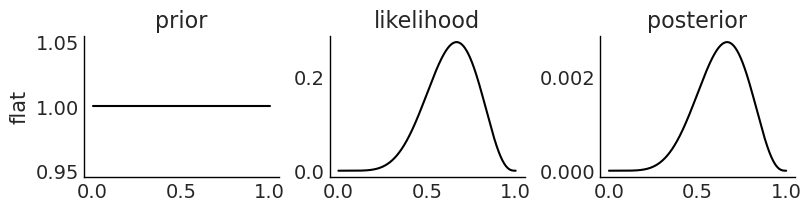

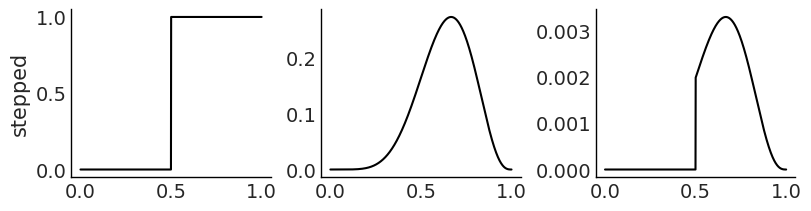

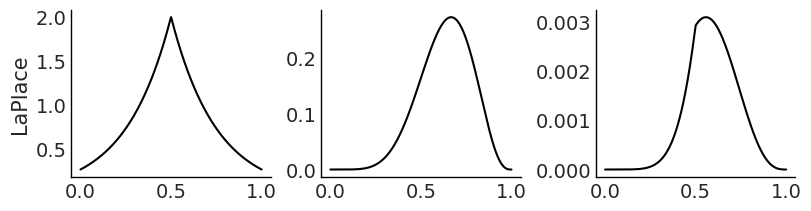

In [33]:
for row in df5_final.row.unique():
    _, axes = plt.subplots(1, 3, figsize=(8, 2))
    for name, ax in zip(df5_final.name.unique(), axes.flatten()):
        df_i = df5_final.query(f"row == '{row}'").query(f"name == '{name}'")
        ax.plot(df_i["probability"], df_i["value"])
        if row == "flat":
            ax.set(title=f"{name}")
    axes[0].set(ylabel=f"{row}")

### 2.4.2 Motors

### 2.4.3 Grid approximation

Code 2.3 and 2.5

Computing the posterior using a grid approximation.

In the book, the following code is not inside a function, but this way it is easier to play with different parameters.


In [34]:
def uniform_prior(n_samples):
    return np.ones(n_samples)


def truncated_prior(n_samples, trunc_point=0.5):
    return (np.linspace(0, 1, n_samples) >= trunc_point).astype(int)


def double_exp_prior(n_samples):
    return np.exp(-5 * abs(np.linspace(0, 1, n_samples) - 0.5))


def grid_approximation(prior_func, n_samples, n_success=6, n_trials=9):
    # define p_grid, prior
    p_grid = np.linspace(0, 1, n_samples)
    prior = prior_func(n_samples)

    # compute likelihood, posterior
    likelihood = stats.binom.pmf(n_success, n_trials, p_grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / np.sum(unstd_posterior)

    return pd.DataFrame({
        "p_grid": p_grid,
        "prior": prior,
        "likelihood": likelihood,
        "unstd_posterior": unstd_posterior,
        "posterior": posterior,
    })


grid_approximation(uniform_prior, 20)

,p_grid,prior,likelihood,unstd_posterior,posterior
0,0.000000,1.0,0.000000,0.000000,0.000000e+00
1,0.052632,1.0,0.000002,0.000002,7.989837e-07
2,0.105263,1.0,0.000082,0.000082,4.307717e-05
3,0.157895,1.0,0.000777,0.000777,4.090797e-04
4,0.210526,1.0,0.003599,0.003599,1.893887e-03
5,0.263158,1.0,0.011161,0.011161,5.873873e-03
6,0.315789,1.0,0.026683,0.026683,1.404294e-02
7,0.368421,1.0,0.052921,0.052921,2.785174e-02
8,0.421053,1.0,0.090827,0.090827,4.780115e-02
9,0.473684,1.0,0.138341,0.138341,7.280739e-02


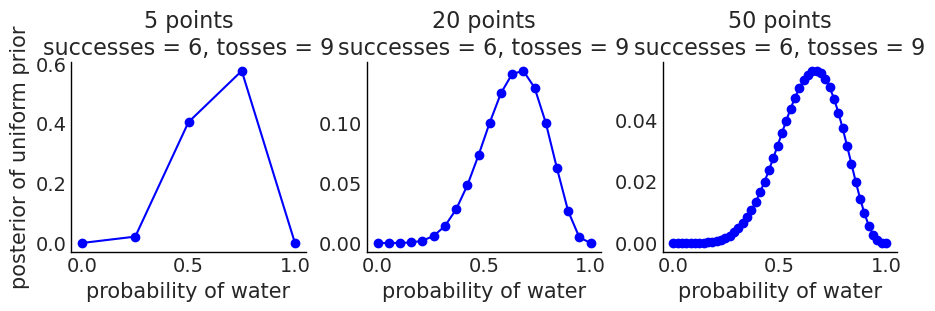

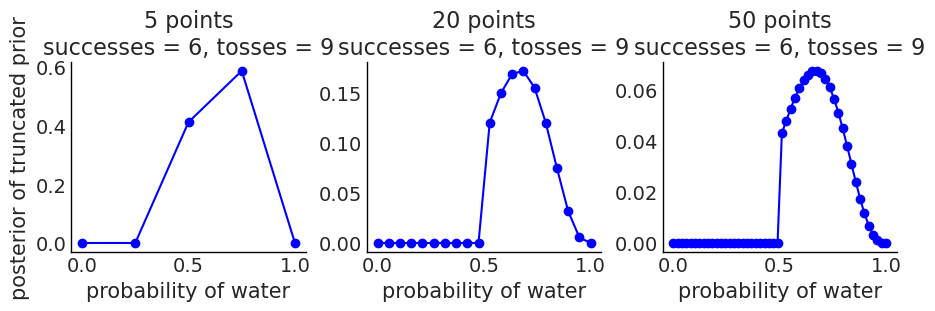

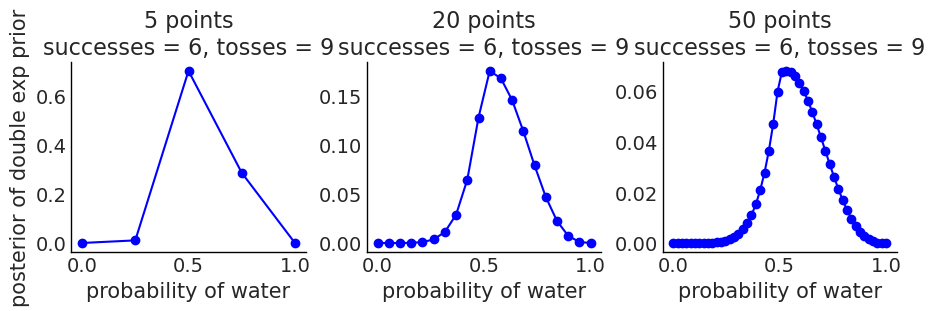

In [35]:
prior_funcs = [uniform_prior, truncated_prior, double_exp_prior]
n_samples = [5, 20, 50]
n_success = 6
n_trials = 9

for prior_func in prior_funcs:
    _, axes = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

    for sample, ax in zip(n_samples, axes.flatten()):
        df_i = grid_approximation(prior_func, sample, n_success, n_trials)
        ax.plot(df_i["p_grid"], df_i["posterior"], "bo-")
        ax.set(title=f"{sample} points\nsuccesses = {n_success}, tosses = {n_trials}")
        ax.set(xlabel="probability of water")

    axes[0].set(ylabel=f"posterior of {prior_func.__name__.replace('_', ' ')}")

### 2.4.4 Quadratic approximation

the following code is verbose due to a bug in PyMC v4 & v5 as mentioned in the [issues](https://github.com/pymc-devs/pymc-resources/issues/222)

Code 2.6

Computing the posterior using the quadratic approximation (quad).


In [36]:
data = np.repeat((0, 1), (3, 6))

with pm.Model() as m:
    # define prior
    p = pm.Uniform("p", 0, 1)
    # define likelihood
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())
    # compute posterior
    mean_q = pm.find_MAP(progressbar=False)

    # Remove transform from the variable `p`
    m.rvs_to_transforms[p] = None
    # Change name so that we can use `mean_q["p"]` value
    p_value = m.rvs_to_values[p]
    p_value.name = p.name

    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

    # display summary of quadratic approximation
    print(f"Mean, Standard deviation\np {mean_q['p']:.2}, {std_q[0]:.2}")

Mean, Standard deviation
p 0.67, 0.16


/Users/integzz/.conda/envs/kaggle/lib/python3.12/site-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)


In [37]:
# Compute the 89% percentile interval
norm = stats.norm(mean_q, std_q)
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
pi = mean_q["p"] + std_q * z
print(f"5.5%, 94.5% \n{pi[0]:.4}, {pi[1]:.4}")

5.5%, 94.5% 
0.4155, 0.9178


Code 2.7

/Users/integzz/.conda/envs/kaggle/lib/python3.12/site-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)
/Users/integzz/.conda/envs/kaggle/lib/python3.12/site-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)
/Users/integzz/.conda/envs/kaggle/lib/python3.12/site-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)


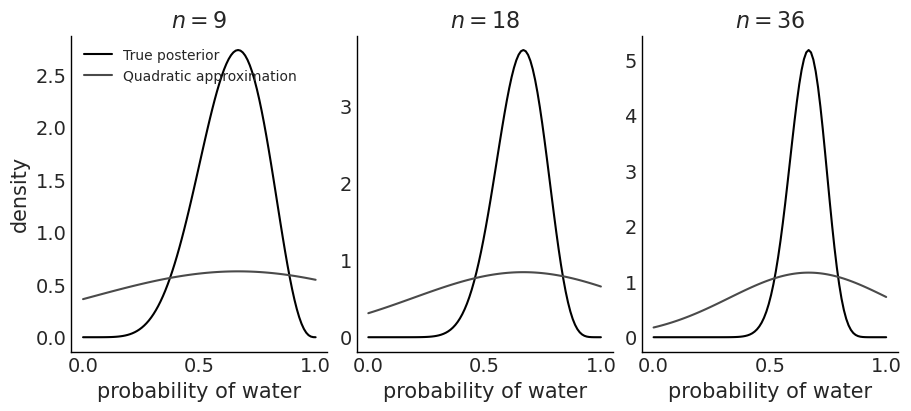

In [38]:
x = np.linspace(0, 1, 100)
w, n = [6, 12, 24], [9, 18, 36]

_, axes = plt.subplots(1, 3, figsize=(9, 4), constrained_layout=True)

for ps, ax in zip(zip(w, n), axes.flatten()):
    data = np.repeat((0, 1), (ps[1] - ps[0], ps[0]))

    with pm.Model() as m:
        p = pm.Uniform("p", 0, 1)
        w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())
        mean_q = pm.find_MAP(progressbar=False)

        p_value = m.rvs_to_values[p]
        p_value.tag.transform = None
        p_value.name = p.name

        std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

    ax.plot(x, stats.beta.pdf(x, ps[0] + 1, ps[1] - ps[0] + 1), label="True posterior")
    ax.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
    ax.set(xlabel="probability of water")
    ax.set(title=f"$n={ps[1]}$")

axes[0].set(ylabel="density")
axes[0].legend(loc="upper left", fontsize="medium")

#### 2.4.4.1 Rethinking: Maximum likelihood estimation

### 2.4.5 Markov chain Monte Carlo

Code 2.8

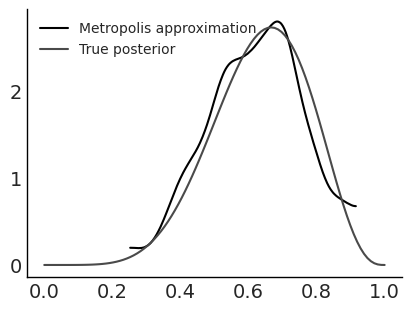

In [39]:
n_samples = 1000
ps = np.zeros(n_samples)
ps[0] = 0.5
W, L = 6, 3

for i in range(1, n_samples):
    p_new = stats.norm(ps[i - 1], 0.1).rvs(1)[0]
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(W, n=W + L, p=ps[i - 1])
    q1 = stats.binom.pmf(W, n=W + L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        ps[i] = p_new
    else:
        ps[i] = ps[i - 1]


_, ax = plt.subplots(figsize=(4, 3))

az.plot_kde(ps, label="Metropolis approximation", ax=ax)

x = np.linspace(0, 1, 100)
ax.plot(x, stats.beta.pdf(x, W + 1, L + 1), "C1", label="True posterior")
ax.legend(loc="upper left", fontsize="medium")